# PBO learnt on several iterations and several weigths

## Define paramters

In [1]:
%load_ext autoreload
%autoreload 2

import jax

# keys
seed = 1
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Box over states and actions
max_discrete_state = 5
n_discrete_states = 7
max_discrete_action = 5
n_discrete_actions = 7

# Weights collection
n_weights = 1

# Q function
action_range_on_max = max_discrete_action
n_actions_on_max = 5000

# PBO training
tolerance = 0.1
max_iterations = 500
batch_size_samples = 20
batch_size_weights = n_weights
learning_rate = {"first": 0.01, "last": 0.0005, "duration": max_iterations}
max_bellman_iterations = 1
add_infinity = False

# Visualisation
plot_freq = 100
weights_range = 1
sleeping_time = 0

## Define environment

In [2]:
import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


discrete_states = np.linspace(-max_discrete_state, max_discrete_state, n_discrete_states)
state_box_half_size = max_discrete_state / n_discrete_states
discrete_states_boxes = np.linspace(
    -max_discrete_state - state_box_half_size, max_discrete_state + state_box_half_size, n_discrete_states + 1
)

discrete_actions = np.linspace(-max_discrete_action, max_discrete_action, n_discrete_actions)
action_box_half_size = max_discrete_action / n_discrete_actions
discrete_actions_boxes = np.linspace(
    -max_discrete_action - action_box_half_size, max_discrete_action + action_box_half_size, n_discrete_actions + 1
)

env = LinearQuadraticEnv(env_key, max_init_state=max_discrete_state)

Transition: s' = As + Ba
Transition: s' = -0.10490131378173828s + -0.6472394466400146a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.21946656703948975s² + -0.19231724739074707a² + -0.11510777473449707sa


## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp

from pbo.sample_collection.replay_buffer import ReplayBuffer


n_samples = n_discrete_states * n_discrete_actions
replay_buffer = ReplayBuffer()

for state in discrete_states:
    for action in discrete_actions:
        env.reset(jnp.array([state]))
        next_state, reward, _, _ = env.step(jnp.array([action]))

        replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state)

replay_buffer.cast_to_jax_array()

### Visualize samples

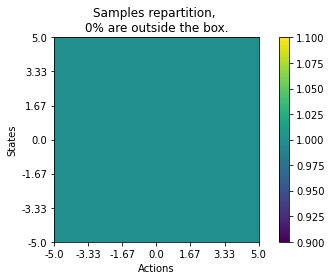

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, discrete_states_boxes, discrete_actions_boxes)
samples_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


## Optimal Q function

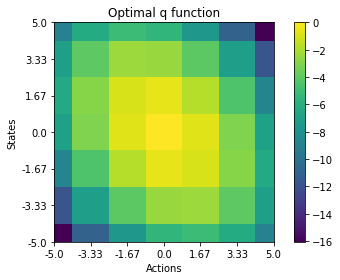

In [5]:
optimal_q = env.optimal_Q_mesh(discrete_states, discrete_actions)

q_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Build q network

In [6]:
from pbo.networks.q import Theoretical1DQ


q = Theoretical1DQ(
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    action_range_on_max=action_range_on_max,
    n_actions_on_max=n_actions_on_max,
    A=env.A[0, 0], B=env.B[0, 0], R=env.R[0, 0], S=env.S[0, 0], P=env.P[0, 0]
)

## Collect weights

### Random init weights

In [7]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

while len(weights_buffer) < n_weights:
    weights_buffer.add(q.random_init_weights())

weights_buffer.cast_to_jax_array()

## Build the PBOs network and the dataloaders

In [8]:
from pbo.networks.pbo import LinearPBO, Optimal1DPBO
from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)

data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)

pbo = LinearPBO(pbo_network_key, q, learning_rate, max_bellman_iterations, add_infinity)
pbo_optimal = Optimal1DPBO(env.A[0, 0], env.B[0, 0], env.Q[0, 0], env.R[0, 0], env.S[0, 0], env.P[0, 0])

## Train PBO on several iteration

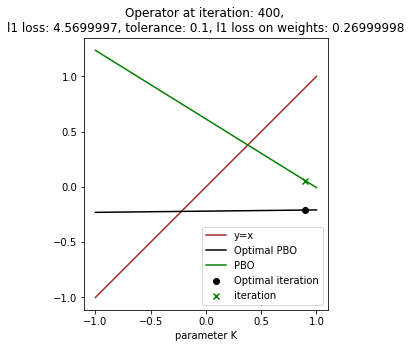

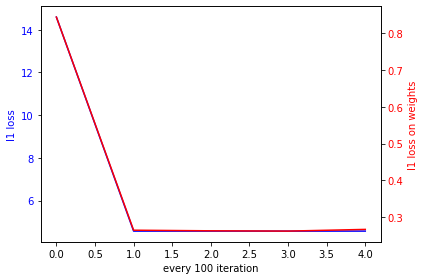

In [9]:
from pbo.utils.operator_viewer import OperatorViewer
from pbo.utils.shared_axis_plot import shared_axis_plot


# For visualization
weights_iterator = OperatorViewer(pbo.network.apply, pbo_optimal, data_loader_weights.weights, weights_range, 0)
full_batch = {
    "state": replay_buffer.states,
    "action": replay_buffer.actions,
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}
l1_losses = []
l1_losses_on_weights = []

iteration = 0
l1_loss = float("inf")
bellman_iterations = jnp.arange(max_bellman_iterations + 1)

while l1_loss > tolerance and iteration < max_iterations:
    cumulative_l2_loss = 0
    
    data_loader_weights.shuffle()
    for batch_weights in data_loader_weights:
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(pbo.params, pbo.optimizer_state, batch_weights, batch_samples)            
            cumulative_l2_loss += l2_loss

    # Visualization
    if iteration % plot_freq == 0:  
        l1_loss = pbo.l1_loss(pbo.params, data_loader_weights.weights, full_batch)
        l1_loss_on_weights = jnp.abs(pbo.network.apply(pbo.params, data_loader_weights.weights) - pbo_optimal(data_loader_weights.weights)).mean()

        weights_iterator.update_pbo_iterations(pbo.params)
        weights_iterator.show(
            f"Operator at iteration: {iteration}, \nl1 loss: {str(np.round(l1_loss, 2))}, tolerance: {tolerance}, l1 loss on weights: {str(np.round(l1_loss_on_weights, 2))}"
        )

        l1_losses.append(l1_loss)
        l1_losses_on_weights.append(l1_loss_on_weights)

    iteration += 1


shared_axis_plot(l1_losses, l1_losses_on_weights, f"every {plot_freq} iteration", "l1 loss", "l1 loss on weights")

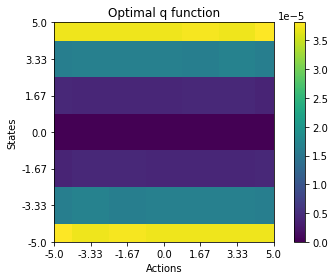

In [10]:
batch_iterated_weights = pbo_optimal(pbo_optimal(pbo_optimal(data_loader_weights.weights)))

q_values = jax.vmap(
    lambda weights: q.network.apply(q.to_params(weights), full_batch["state"], full_batch["action"])
)(batch_iterated_weights).reshape((n_discrete_states, n_discrete_actions))

q_visu_mesh.set_values(q_values - optimal_q)
q_visu_mesh.show("Optimal q function")

In [51]:
weight = jnp.array([-2.22])
I = env.S + env.A * env.B * env.P 
M = env.R + env.B**2 * env.P 

print('Weight', weight)

for i in range(1, n_samples):
    state = replay_buffer.states[i: i + 1]
    # print('State', replay_buffer.states[i: i + 1])
    action = replay_buffer.actions[i: i + 1]
    # print('Action', replay_buffer.actions[i: i + 1])
    reward = replay_buffer.rewards[i, i + 1]
    # print('Reward', replay_buffer.rewards[i: i + 1])
    next_state = replay_buffer.next_states[i: i + 1]
    # print('Next state', next_state)
    # print('true arg max', - next_state * I / M)
    # print()

    target = reward  + q.max_value(q.to_params(weight), next_state)
    # print('target', target)

    optimal_target = q.network.apply(q.to_params(pbo_optimal(weight.reshape((-1, 1)))), state, action)
    # print("optimal target", optimal_target)

    true_target = reward + q.network.apply(q.to_params(weight), next_state, - next_state * I / M)
    # print("true target", true_target)

    if np.abs(target - true_target)[0, 0] > 1e-5:
        print("target")
        print(np.abs(target - true_target)[0, 0])

    if np.abs(optimal_target - true_target)[0, 0] > 1e-5:
        print("optimal")
        print(np.abs(optimal_target - true_target)[0, 0])
    print()

Weight [-2.22]
optimal
13.823935

optimal
4.586624


optimal
0.064064026

optimal
4.7788157

optimal
14.144255

optimal
25.450657

optimal
12.316416

optimal
3.8328633


optimal
0.8178239

optimal
6.2863355

optimal
16.405535

optimal
23.189375

optimal
10.808895

optimal
3.079104


optimal
1.5715839

optimal
7.7938547

optimal
18.666815

optimal
20.928095

optimal
9.301374

optimal
2.3253436


optimal
2.3253436

optimal
9.301374

optimal
20.928095

optimal
18.666815

optimal
7.7938547

optimal
1.5715839


optimal
3.079104

optimal
10.808895

optimal
23.189375

optimal
16.405535

optimal
6.2863355

optimal
0.8178239


optimal
3.8328633

optimal
12.316416

optimal
25.450657

optimal
14.144255

optimal
4.7788157

optimal
0.064064026


optimal
4.586624

optimal
13.823935

optimal
27.711935



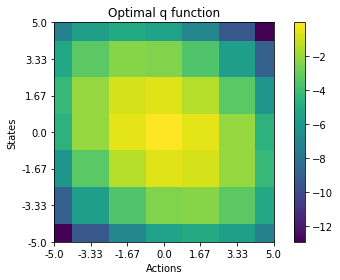

In [12]:
true_bellman_q = pbo.compute_target(jnp.array([[0.0000000103]]), full_batch).reshape((n_discrete_states, n_discrete_actions))

q_visu_mesh.set_values(true_bellman_q)
q_visu_mesh.show("Optimal q function")

In [13]:
            batch_targets = pbo.compute_target(batch_iterated_weights, sample)

            batch_iterated_weights = self(batch_iterated_weights)

            q_values = jax.vmap(
                lambda weights: q.network.apply(q.to_params(weights), sample["state"], sample["action"])
            )(batch_iterated_weights)

            loss += jnp.abs(q_values - batch_targets).mean()

NameError: name 'sample' is not defined

## Performances of the operators

In [ ]:
l1_loss_optimal = pbo_optimal.l1_loss(pbo, q, data_loader_weights.weights, full_batch, max_bellman_iterations, add_infinity)

print("l1 loss", l1_loss)
print("l1 loss optimal", l1_loss_optimal)

In [ ]:
q_thin = Theoretical1DQ(
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    action_range_on_max=10 * action_range_on_max,
    n_actions_on_max=1000 * n_actions_on_max,
    A=env.A[0, 0], B=env.B[0, 0], R=env.R[0, 0], S=env.S[0, 0], P=env.P[0, 0]
)

pbo_thin = LinearPBO(pbo_network_key, q_thin, learning_rate, max_bellman_iterations, add_infinity)

l1_loss_optimal_thin = pbo_optimal.l1_loss(pbo_thin, q_thin, data_loader_weights.weights, full_batch, max_bellman_iterations, add_infinity)

print("l1 loss optimal thin scale", l1_loss_optimal_thin)

## Visualize iterations on weights

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def add_points(ax, points, size, label, color):
    xdata = points[:, 0]
    ydata = points[:, 1]
    zdata = points[:, 2]
    ax.scatter3D(xdata, ydata, zdata, s=size, label=label, color=color)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
sizes = [1, 5, 300, 1000]
colors = ["black", "b", "red", "g"]
iterated_weights = weights_buffer.weights

for iteration in range(4):
    add_points(ax, iterated_weights, sizes[iteration], f"iteration {iteration}", colors[iteration])
    iterated_weights = pbo_optimal(iterated_weights)

ax.set_xlabel('k')
ax.set_xticklabels([])
ax.set_xticks([])

ax.set_ylabel('i')
ax.set_yticklabels([])
ax.set_yticks([])

ax.set_zlabel('m')
ax.set_zlim(-2, 5)

ax.legend()
ax.view_init(0, 0)
fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')

iterated_weights = weights_buffer.weights

for iteration in range(4):
    add_points(ax, iterated_weights, sizes[iteration], f"iteration {iteration}", colors[iteration])
    iterated_weights = pbo_optimal_linear.network.apply(pbo_optimal_linear.params, iterated_weights)

ax.set_xlabel('k')
ax.set_xticklabels([])
ax.set_xticks([])

ax.set_ylabel('i')
ax.set_yticklabels([])
ax.set_yticks([])

ax.set_zlabel('m')
ax.set_zlim(-2, 5)

ax.legend()
ax.view_init(0, 0)
fig.tight_layout()
print("Contracting facteur", jnp.linalg.norm(pbo_optimal_linear.params["LinearPBONet/linear"]["w"], ord=1))

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')

iterated_weights = weights_buffer.weights

for iteration in range(4):
    add_points(ax, iterated_weights, sizes[iteration], f"iteration {iteration}", colors[iteration])
    iterated_weights = pbo.network.apply(pbo.params, iterated_weights)

ax.set_xlabel('k')
ax.set_xticklabels([])
ax.set_xticks([])

ax.set_ylabel('i')
ax.set_yticklabels([])
ax.set_yticks([])

ax.set_zlabel('m')
ax.set_zlim(-2, 5)

ax.legend()
ax.view_init(0, 0)
fig.tight_layout()
print("Contracting facteur", jnp.linalg.norm(pbo.params["LinearPBONet/linear"]["w"], ord=1))